### Import Libraries and reading the dataset

In [23]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.image import imread

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import load_model

In [2]:
cwd = os.getcwd()
train_images_path = cwd + '\\Datasets\\cell_images\\cell_images\\train'
train_images_parasitized = cwd + '\\Datasets\\cell_images\\cell_images\\train\\parasitized'
train_images_uninfected = cwd + '\\Datasets\\cell_images\\cell_images\\train\\uninfected'

test_images_path = cwd + '\\Datasets\\cell_images\\cell_images\\test'
test_images_parasitized = cwd + '\\Datasets\\cell_images\\cell_images\\test\\parasitized'
test_images_uninfected = cwd + '\\Datasets\\cell_images\\cell_images\\test\\uninfected'

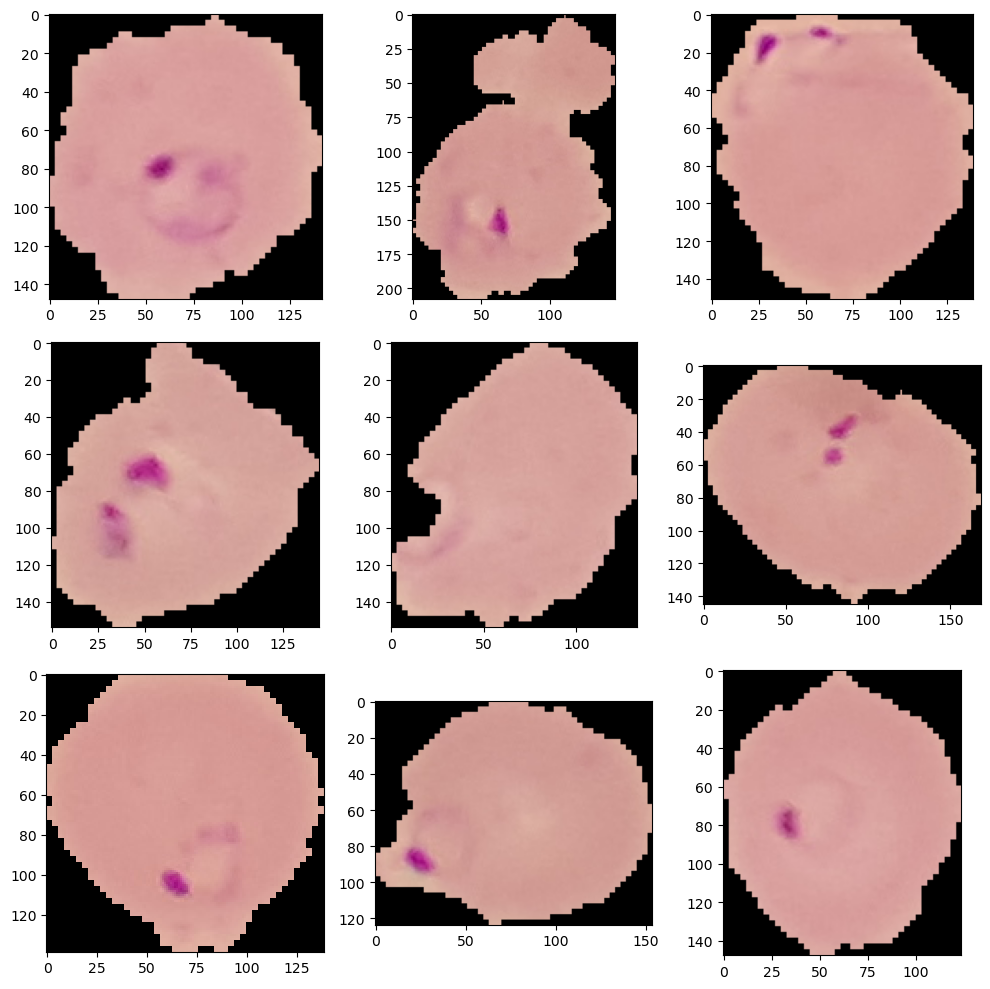

In [3]:
#display images
plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imread('Datasets/cell_images/cell_images/train/Parasitized/'+ os.listdir(train_images_parasitized)[i]))
plt.tight_layout()

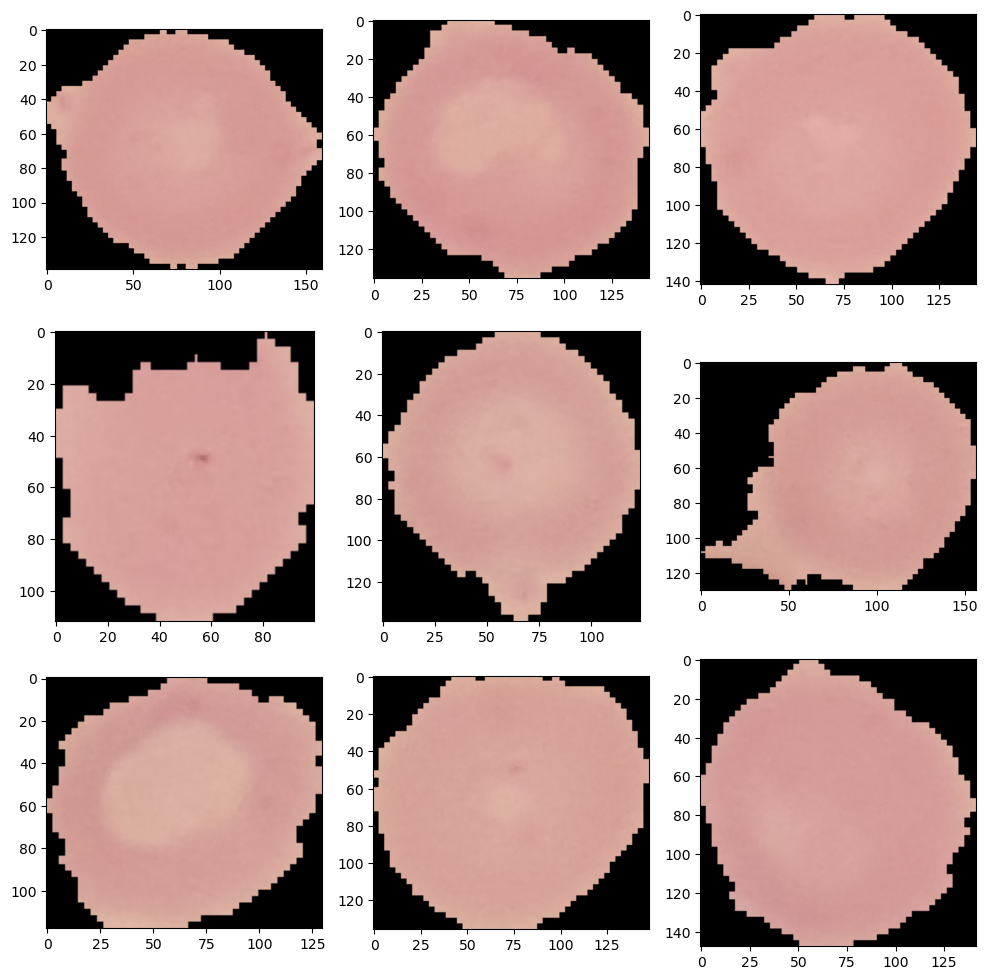

In [4]:
#display images
plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imread('Datasets/cell_images/cell_images/train/uninfected/'+ os.listdir(train_images_uninfected)[i]))
plt.tight_layout()

#### We can observe that all of the images have varying dimensions


In [5]:
# check the number of images

print(len(os.listdir(train_images_parasitized)))
print(len(os.listdir(train_images_uninfected)))
print(len(os.listdir(test_images_parasitized)))
print(len(os.listdir(test_images_uninfected)))


12479
12480
1300
1300


In [6]:
# check the dimensions of the images
for i in range(5):
    image = imread('Datasets/cell_images/cell_images/train/Parasitized/'+ os.listdir(train_images_parasitized)[i])
    print(image.shape)
    

(148, 142, 3)
(208, 148, 3)
(151, 139, 3)
(154, 145, 3)
(154, 133, 3)


In [7]:
# check the stats of the dimensions
dimension_1 = []
dimension_2 = []
for image in os.listdir(train_images_parasitized):
    img = imread('Datasets/cell_images/cell_images/train/Parasitized/'+ image)
    dimension_1.append(img.shape[0])
    dimension_2.append(img.shape[1])

In [8]:
pd.DataFrame(data = [dimension_1, dimension_2]).T.describe()

,0,1
count,12479.000000,12479.000000
mean,134.360205,133.664476
std,21.891205,21.137344
min,40.000000,46.000000
25%,121.000000,121.000000
50%,133.000000,133.000000
75%,145.000000,145.000000
max,382.000000,394.000000


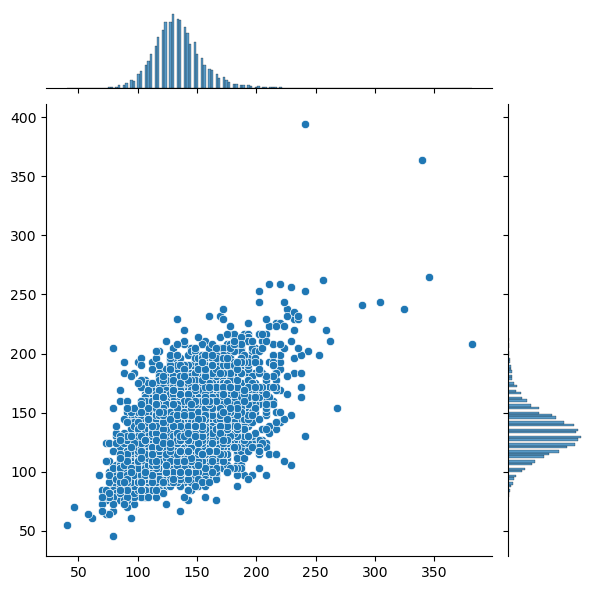

In [9]:
sns.jointplot(x = dimension_1, y = dimension_2)

In [10]:
# we can observe that the mean of the dimensions is 134 and 133 - hence we set the shape to 135,135 across 3 channels
image_shape = (135, 135, 3)

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

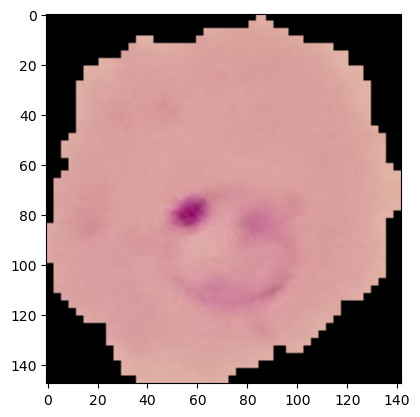

In [12]:
image_path = imread('Datasets/cell_images/cell_images/train/Parasitized/'+ os.listdir(train_images_parasitized)[0])
plt.imshow(image_path)

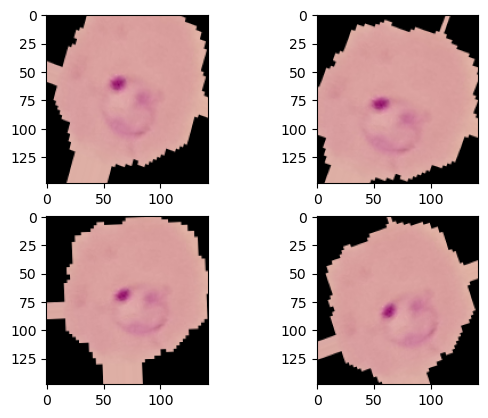

In [13]:
for i in range(4):
    plt.subplot(2,2, i+1)
    plt.imshow(image_gen.random_transform(image_path))

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [14]:
image_gen.flow_from_directory(train_images_path)
image_gen.flow_from_directory(test_images_path)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [15]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 133, 133, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 66, 66, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,899,777 (7.25 MB)

 Trainable params: 1,899,777 (7.25 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [18]:
train_image_gen = image_gen.flow_from_directory(train_images_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_images_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [85]:
results = model.fit(train_image_gen,epochs=20,
                            validation_data=test_image_gen,
                            callbacks=[early_stop])

Epoch 1/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 689s 439ms/step - accuracy: 0.5462 - loss: 0.6883 - val_accuracy: 0.7512 - val_loss: 0.5118
Epoch 2/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 460s 294ms/step - accuracy: 0.8147 - loss: 0.4388 - val_accuracy: 0.9250 - val_loss: 0.2044
Epoch 3/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 374s 239ms/step - accuracy: 0.9369 - loss: 0.1914 - val_accuracy: 0.9454 - val_loss: 0.1757
Epoch 4/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 389s 249ms/step - accuracy: 0.9481 - loss: 0.1692 - val_accuracy: 0.9419 - val_loss: 0.1725
Epoch 5/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 375s 240ms/step - accuracy: 0.9476 - loss: 0.1682 - val_accuracy: 0.9438 - val_loss: 0.1651
Epoch 6/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 396s 253ms/step - accuracy: 0.9502 - loss: 0.1604 - val_accuracy: 0.9442 - val_loss: 0.1594
Epoch 7/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 379s 243ms/step - accuracy: 0.9498 - loss: 0.1569 - val_accuracy: 0.9523 - val_loss: 0.1498
Epoch 8/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 398s 255ms/step - ac

In [24]:
model = load_model('malaria_detector.h5')

In [91]:
#model.save('malaria_detector.h5')

# Evaluation

In [89]:
metrics = pd.DataFrame(data = [results.history['accuracy'], results.history['val_accuracy'] , results.history['loss'], results.history['val_loss']], index = ['accuracy', 'val_accuracy', 'loss', 'val_loss']).T

In [92]:
metrics

,accuracy,val_accuracy,loss,val_loss
0,0.567594,0.751154,0.680254,0.511819
1,0.873187,0.925000,0.336164,0.204404
2,0.940500,0.945385,0.184959,0.175713
3,0.946991,0.941923,0.171475,0.172509
4,0.950036,0.943846,0.165511,0.165083
5,0.951478,0.944231,0.158117,0.159431
6,0.950557,0.952308,0.158062,0.149817
7,0.952039,0.945769,0.155034,0.147992
8,0.953802,0.943077,0.151353,0.175589
9,0.952039,0.947692,0.151518,0.158026


<Axes: >

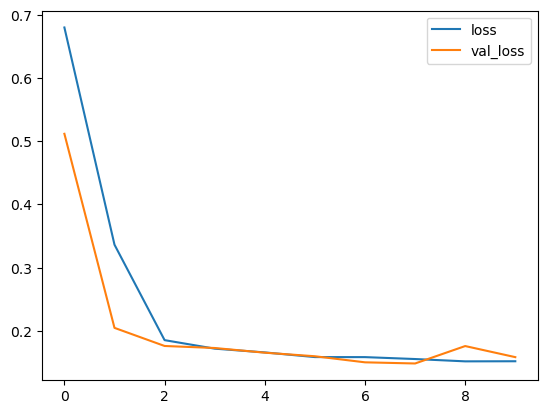

In [93]:
metrics[['loss', 'val_loss']].plot()

<Axes: >

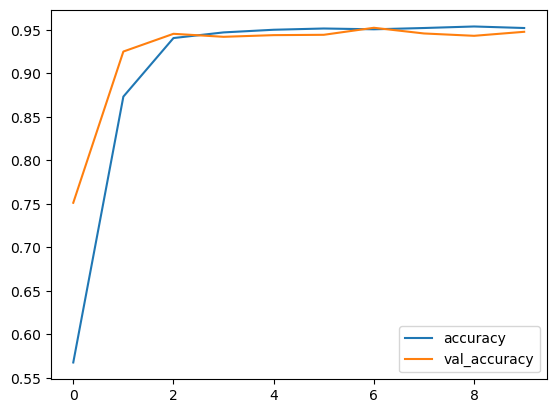

In [95]:
metrics[['accuracy', 'val_accuracy']].plot()

In [31]:
preds = model.predict(test_image_gen)
preds

163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step


array([[9.5583892e-01],
       [1.5462280e-04],
       [4.5711968e-02],
       ...,
       [9.7104460e-01],
       [9.8323125e-01],
       [8.3796522e-03]], dtype=float32)

In [42]:
actual = test_image_gen.classes
actual[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
prediction = preds > 0.5
prediction

array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

In [112]:
print(classification_report(actual,prediction))

              precision    recall  f1-score   support

           0       0.51      0.49      0.50      1300
           1       0.51      0.52      0.51      1300

    accuracy                           0.51      2600
   macro avg       0.51      0.51      0.51      2600
weighted avg       0.51      0.51      0.51      2600



In [113]:
confusion_matrix(test_image_gen.classes,prediction)

array([[643, 657],
       [628, 672]], dtype=int64)